In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean

In [2]:
df = pd.read_csv(r'D:\AKG\Dataset\boids\boids_python2\dataframe25.csv')
df

,Time,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x20,y20,x21,y21,x22,y22,x23,y23,x24,y24
0,0.0,2568.659912,2537.387397,2522.732838,2548.988080,2530.087893,2509.279143,2508.831524,2502.004734,2525.486076,...,2562.558591,2563.052463,2542.483784,2502.633602,2562.051039,2549.810653,2526.973922,2537.605299,2553.794086,2552.107004
1,1.0,2571.651252,2537.615181,2522.468708,2551.976430,2527.122785,2508.822928,2507.569282,2499.283201,2522.757163,...,2563.041545,2560.091592,2540.029515,2504.358874,2564.197109,2547.714375,2529.740138,2536.444245,2554.949838,2549.338568
2,2.0,2574.650709,2537.558145,2521.741772,2554.887026,2524.278060,2507.870280,2506.196724,2496.615602,2520.198791,...,2563.893844,2557.215208,2537.386425,2505.778055,2566.634680,2545.965590,2530.808152,2533.640793,2556.668559,2546.879707
3,3.0,2577.649144,2537.461243,2520.630870,2557.673761,2521.651442,2506.420838,2504.834609,2493.942656,2517.857712,...,2565.140648,2554.486567,2534.566857,2506.802768,2569.262411,2544.518168,2528.630580,2531.577258,2558.852748,2544.823175
4,4.0,2580.646478,2537.334787,2519.313210,2560.368900,2519.245015,2504.629440,2503.467932,2491.272039,2515.691495,...,2566.780731,2551.974571,2531.616244,2507.344879,2572.012365,2543.319104,2527.365805,2528.856900,2561.373240,2543.196178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,885.0,3518.992198,3443.382522,3320.498498,4761.084863,813.225397,1683.588151,1938.060810,8572.194038,1646.450324,...,4344.802478,4037.433041,954.177845,1546.726472,4413.294599,2487.846018,1266.227641,3332.756517,4147.576992,2963.447848
886,886.0,3515.997053,3443.211920,3321.531187,4763.901520,810.538453,1682.253860,1937.423257,8569.262566,1644.372304,...,4347.145419,4039.306709,951.521308,1545.332624,4416.290268,2488.007160,1263.808250,3334.530368,4150.490116,2964.164580
887,887.0,3513.001907,3443.041319,3322.563876,4766.718176,807.851510,1680.919568,1936.785705,8566.331094,1642.294284,...,4349.488359,4041.180376,948.864771,1543.938777,4419.285937,2488.168303,1261.388859,3336.304219,4153.403241,2964.881311
888,888.0,3510.006762,3442.870717,3323.596566,4769.534832,805.164566,1679.585277,1936.148152,8563.399622,1640.216265,...,4351.831299,4043.054044,946.208234,1542.544930,4422.281606,2488.329446,1258.969468,3338.078070,4156.316366,2965.598043


In [3]:
sequence_length = 7
time_series_data = df.iloc[:, 1:].values

mean = np.mean(time_series_data, axis=0)
std = np.std(time_series_data, axis=0)
time_series_data_normalized = (time_series_data - mean) / std

In [4]:
X = []
y = []
for i in range(len(time_series_data_normalized) - sequence_length - 1):
    X.append(time_series_data_normalized[i:i+sequence_length])
    y.append(time_series_data_normalized[i+sequence_length+1])
X = np.array(X)
y = np.array(y)

# split_index = int(0.8 * len(X))  # 80% training, 20% validation
X_train, X_val, X_test = X[:700], X[700:850], X[850:]
y_train, y_val, y_test = y[:700], y[700:850], y[850:]


In [5]:
len(time_series_data_normalized), X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(890, (700, 7, 50), (700, 50), (150, 7, 50), (150, 50), (32, 7, 50), (32, 50))

In [56]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df, 7)
X1.shape, y1.shape

((883, 7, 1, 51), (883, 51))

In [9]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, 50)))
model.add(LSTM(64, activation='relu')) 
model.add(Dense(50))

model.compile(loss='mse', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 128)            91648     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 144,306
Trainable params: 144,306
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
 1/22 [>.............................] - ETA: 0s - loss: 3.8730e-04 - accuracy: 1.0000

22/22 [==============================] - 0s 11ms/step - loss: 4.2275e-04 - accuracy: 0.9414 - val_loss: 0.9894 - val_accuracy: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 3.5864e-04 - accuracy: 0.9543 - val_loss: 0.9960 - val_accuracy: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 2.5428e-04 - accuracy: 0.9629 - val_loss: 0.9959 - val_accuracy: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 2.3673e-04 - accuracy: 0.9686 - val_loss: 0.9836 - val_accuracy: 0.0000e+00
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 2.4232e-04 - accuracy: 0.9671 - val_loss: 0.9979 - val_accuracy: 0.0000e+00
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 2.2824e-04 - accuracy: 0.9714 - val_loss: 0.9943 - val_accuracy: 0.0000e+00
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 3.4262e-04 - accuracy: 0.9614 - val_loss: 0.

0.9814285635948181


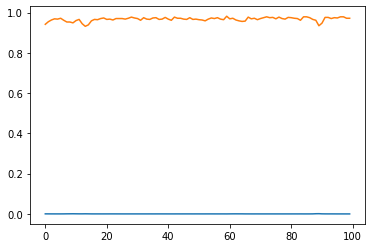

In [17]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.plot(model.history.history['accuracy'])
print(max(model.history.history['accuracy']))

In [13]:
threshold = 1
actual_row = time_series_data[-1]
euclidean_dist = euclidean(actual_row, next_row[0])
accuracy = int(euclidean_dist < threshold)

print("Accuracy Score:", accuracy)

Accuracy Score: 0


In [12]:
last_five_rows = time_series_data_normalized[-sequence_length:]
next_row_normalized = model.predict(np.expand_dims(last_five_rows, axis=0))
next_row = next_row_normalized * std + mean

print("Next Row Prediction:")
print(next_row)

1/1 [==============================] - 0s 416ms/step
Next Row Prediction:
[[3995.27068519 3517.51937242 3136.0905539  4580.74531035 1094.00936926
  1843.78084332 1966.17275472   97.27386193 1850.40550127 1549.35229656
  1319.1299664  3324.77722672  904.17485234 2147.82184865 2923.0609475
  1847.98642812 4058.65025512 4025.34717835 2877.6055096  1716.91453034
  3754.21739055 2221.61722272 1413.93106115 1784.24930988 4079.48976166
  3344.06065006 3919.49456791 2973.06178571 1214.79560529 2010.43429586
  2254.81674973 4277.28860007 3768.88180391 1409.58426217 1940.81838223
  1838.12271979 3968.30138335 3813.95534036 1512.59208324 4691.20768116
  4207.22990889 3634.17164114 1474.99444276 1746.23082946 4008.61662644
  2486.67751225 1459.85549071 3000.00630864 3625.92961827 2839.51675815]]


In [ ]:
l5 = last_five_rows*std + mean

for i in range(0, len(l5)):
    print(l5[i])

next_row[0]

In [39]:
preds = model.predict(X_test)
preds[31]

1/1 [==============================] - 0s 33ms/step


array([ 1.2224333 ,  0.8800508 ,  1.0359327 ,  1.5351225 , -1.4355742 ,
       -1.29801   , -1.0294659 , -0.63700604, -1.2590513 , -1.4924223 ,
       -1.083777  ,  1.7106818 , -1.081224  , -1.4935681 ,  1.3698432 ,
       -1.7267507 ,  1.050058  ,  1.1039598 ,  1.2509556 , -1.6201715 ,
        1.2143855 , -0.30578497, -1.617523  , -1.2457608 ,  1.6955223 ,
        1.3296785 ,  1.3227731 ,  0.74284595, -1.3921325 , -0.9644634 ,
        0.28019708,  0.9326647 ,  1.395841  , -1.0223582 , -1.2820454 ,
       -1.4147329 ,  1.4420793 ,  1.2107323 , -0.86686057,  1.1668893 ,
        1.3980092 ,  1.1506797 , -1.2239364 , -1.4646205 ,  0.63990206,
        0.11770965, -1.3565524 ,  1.3428006 ,  1.4316108 ,  1.6664107 ],
      dtype=float32)

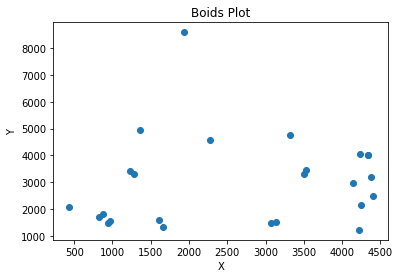

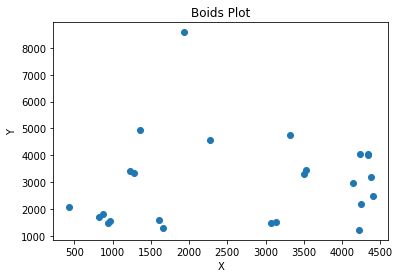

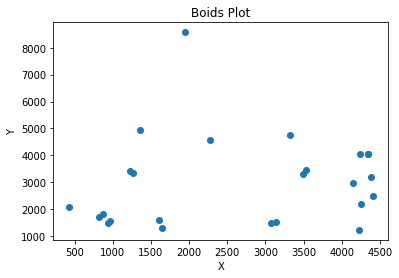

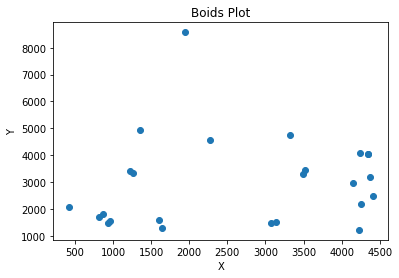

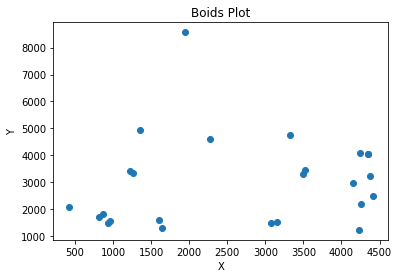

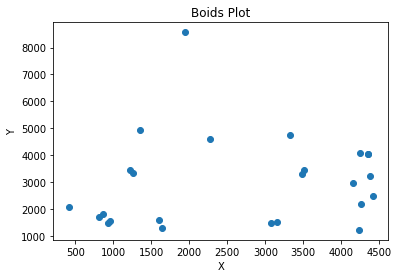

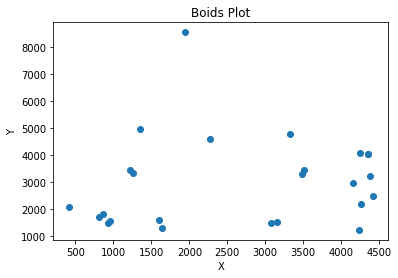

In [35]:
for j in range(0,7):
    ids = []
    x_values = []
    y_values = []

    row = X_test[31][j]*std + mean

    for i in range(0, 25):
        # ids.append(int(row[i][0]))
        x_values.append(float(row[2*i]))
        y_values.append(float(row[2*i + 1]))

    plt.scatter(x_values, y_values)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Boids Plot')
    plt.show()

In [40]:
preds = model.predict(X_test)
preds[31], y_test[31]

1/1 [==============================] - 0s 36ms/step


(array([ 1.2224333 ,  0.8800508 ,  1.0359327 ,  1.5351225 , -1.4355742 ,
        -1.29801   , -1.0294659 , -0.63700604, -1.2590513 , -1.4924223 ,
        -1.083777  ,  1.7106818 , -1.081224  , -1.4935681 ,  1.3698432 ,
        -1.7267507 ,  1.050058  ,  1.1039598 ,  1.2509556 , -1.6201715 ,
         1.2143855 , -0.30578497, -1.617523  , -1.2457608 ,  1.6955223 ,
         1.3296785 ,  1.3227731 ,  0.74284595, -1.3921325 , -0.9644634 ,
         0.28019708,  0.9326647 ,  1.395841  , -1.0223582 , -1.2820454 ,
        -1.4147329 ,  1.4420793 ,  1.2107323 , -0.86686057,  1.1668893 ,
         1.3980092 ,  1.1506797 , -1.2239364 , -1.4646205 ,  0.63990206,
         0.11770965, -1.3565524 ,  1.3428006 ,  1.4316108 ,  1.6664107 ],
       dtype=float32),
 array([ 0.13573565,  1.00355597,  1.77857341,  1.7948641 , -1.99878622,
        -2.02972503, -1.74349881,  4.81750248, -2.3581833 , -2.31173001,
        -2.03726059,  2.09491971, -1.85751449, -1.83306299,  2.32854772,
        -2.24472655,  1.812

In [ ]:
compare = [[y_test], [preds]]
for j in range(0,2):
    ids = []
    x_values = []
    y_values = []

    row = compare[j][31]*std + mean

    for i in range(0, 25):
        # ids.append(int(row[i][0]))
        x_values.append(float(row[2*i]))
        y_values.append(float(row[2*i + 1]))

    plt.scatter(x_values, y_values)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Boids Plot')
    plt.show()

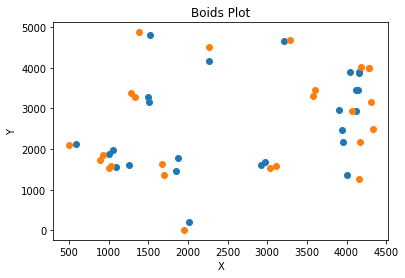

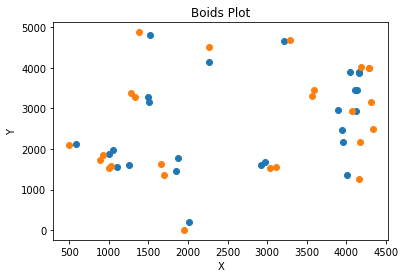

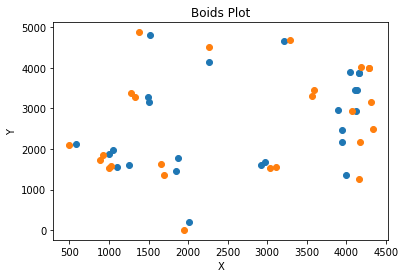

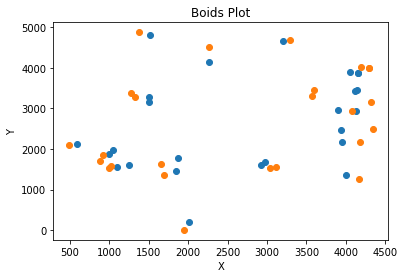

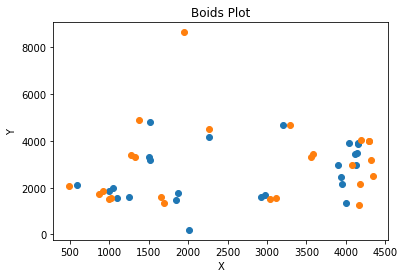

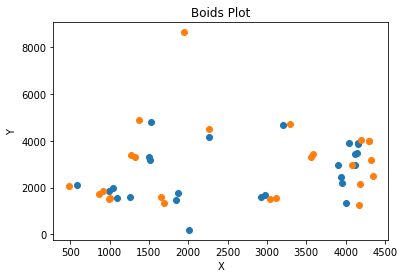

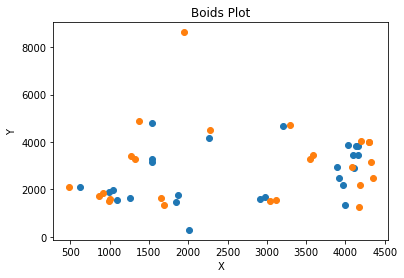

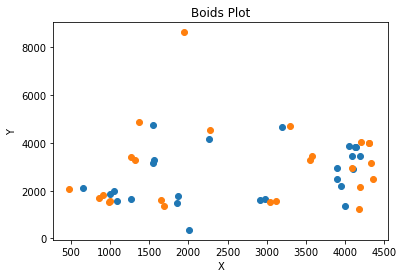

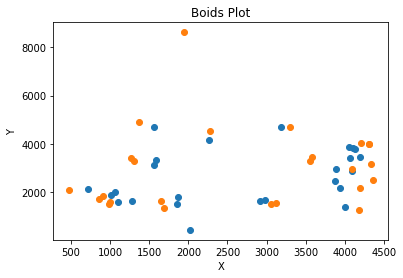

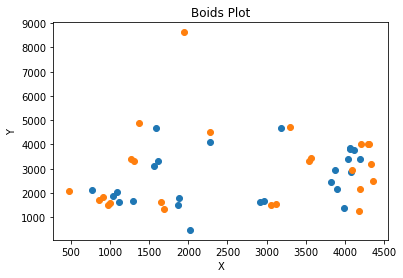

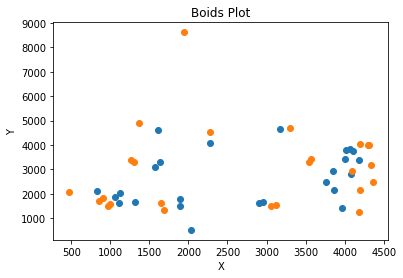

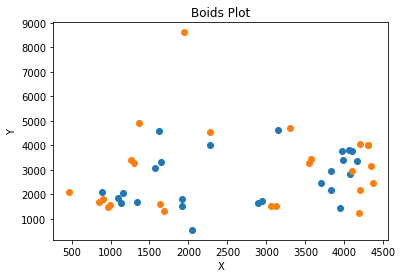

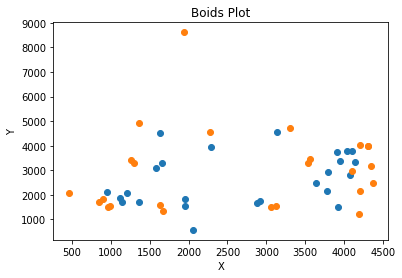

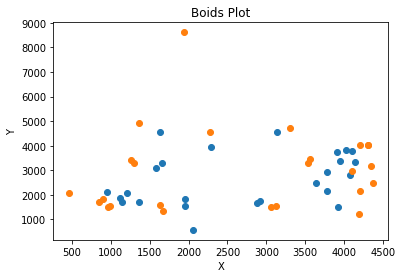

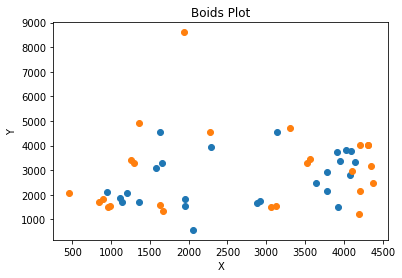

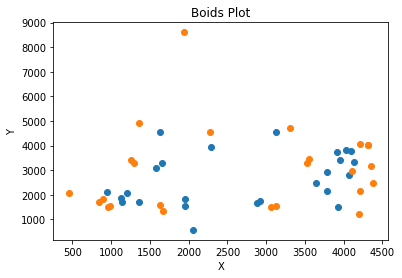

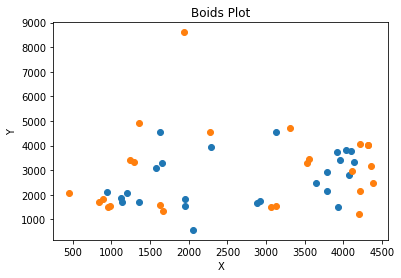

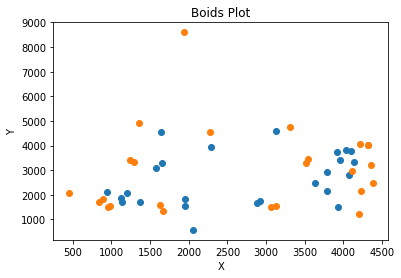

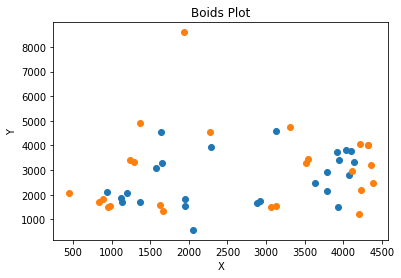

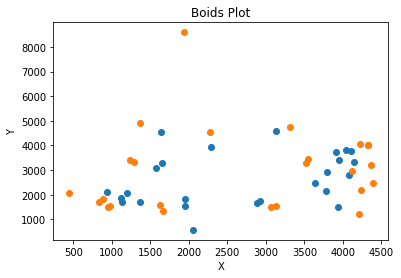

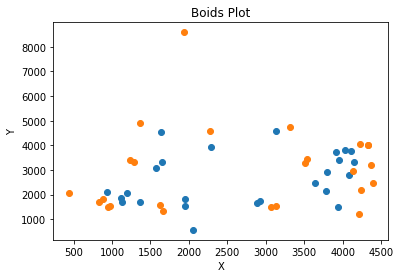

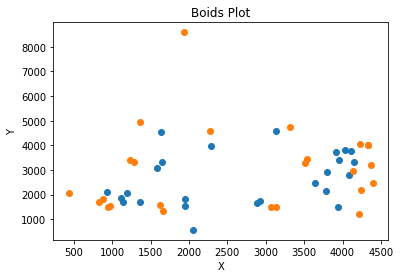

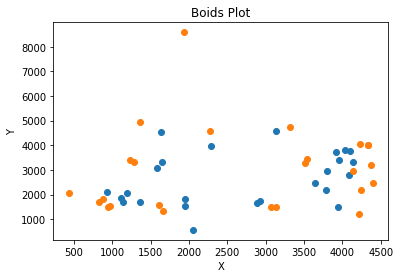

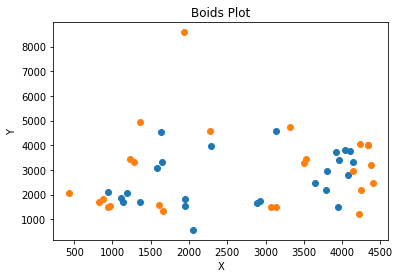

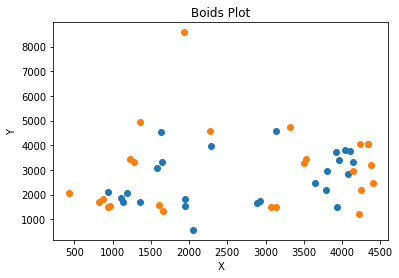

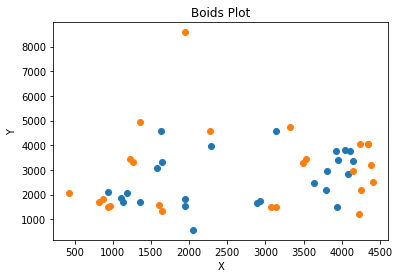

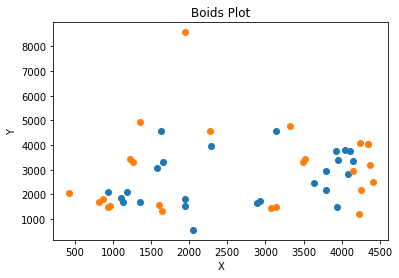

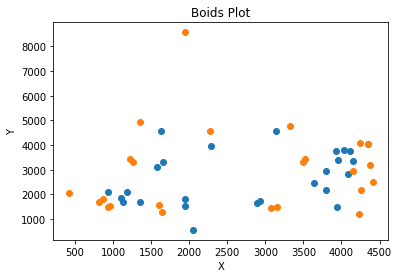

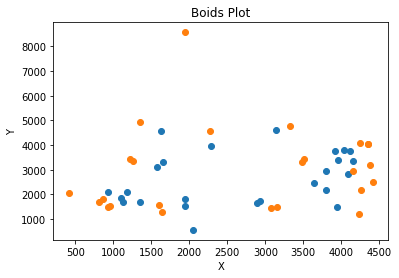

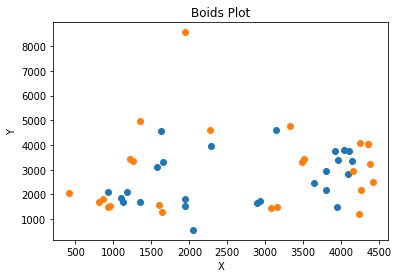

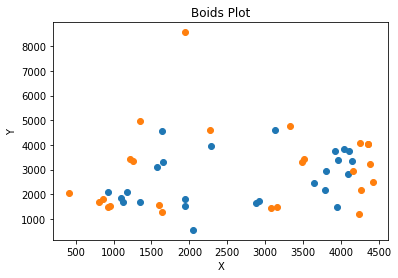

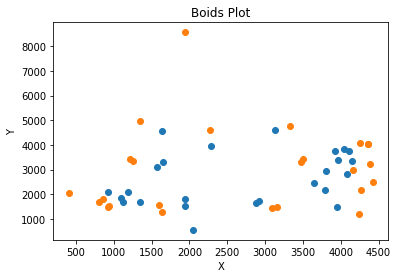

In [53]:
for j in range(0, 32):
    x_values = []
    y_values = []
    xl = []
    yl = []

    row = preds[j]*std + mean
    rows = y_test[j]*std + mean

    for i in range(0, 25):
        x_values.append(float(row[2*i]))
        y_values.append(float(row[2*i + 1]))
        xl.append(float(rows[2*i]))
        yl.append(float(rows[2*i+1]))

    plt.scatter(x_values, y_values)
    plt.scatter(xl, yl)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Boids Plot')
    plt.show()